In [234]:
!pip install geopandas
!pip install scipy==1.7.3
!pip install pymc3

In [235]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import regex as re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

In [236]:
# Read in 2 CSV files called "county_pops.csv" and "county_pops" using pandas
combined = pd.read_csv("pm25_Jan2015.csv").drop(columns=["Unnamed: 0"])
county_pops = pd.read_csv("county_pops.csv", header = 3)
county_pops = county_pops.dropna().loc[:, ["Unnamed: 0", "2015", "2016", "2017", "2018", "2019"]].transpose().reset_index()

## Merging population and weather by county data

In [237]:
# merged_table
# Rename the columns using the first row as the new column names, and drop the first row
county_pops_new_cols = county_pops.rename(county_pops.iloc[0, :], axis = 1).drop(0)

# Reshape the dataframe to a long format, with columns "year", "Counties", and "population"
county_pops_new =  county_pops_new_cols.melt(id_vars=['Unnamed: 0'], var_name='Counties', value_name='population')

# Rename the "Unnamed: 0" column to "year" and convert it to a numeric data type
county_pops_new = county_pops_new.rename(columns={"Unnamed: 0": "year"})
county_pops_new["year"] = pd.to_numeric(county_pops_new["year"])

# Extract the county names from the "Counties" column and add them as a new column "NAME"
county_pattern =  r"\.([A-Za-z\s]+?)\s+County,\s+California"
county_pops_new["NAME"] = county_pops_new["Counties"].str.extract(county_pattern)

# Drop any rows with missing values in the "NAME" column
county_pops_new = county_pops_new.dropna()

# Merge the county population data with the combined dataset based on "year" and "NAME"
merged_table = pd.merge(combined, county_pops_new, on=['year', 'NAME'])

# Drop the "Counties" column from the merged table
merged_table = merged_table.drop(columns=["Counties"])

# Convert the "population" column to numeric data type and remove any commas in the values. 
# Calculate the percent population based on the total population of California (39538223)
merged_table["population"] = pd.to_numeric(merged_table["population"].str.replace(',', ''))
merged_table["percent_pop"] = merged_table.population / 39538223


# Read in the weather data and extract the county names from the "Location" column
# Merge the weather data with the merged table based on county names
weather = pd.read_csv("4-tavg-201901-48.csv")
weather["County"] = weather["Location"].str.extract(r'\b(\w+)\b')
merged_table = pd.merge(merged_table, weather, left_on=['NAME'], right_on=['County'])

# Calculate the population density in square meters
merged_table["pop_density_m2"] = merged_table.population / merged_table.ALAND

# Drop unnecessary columns from the merged table
merged_table.drop(columns=["LSAD", "CLASSFP", "MTFCC", "METDIVFP", "Location ID", "Location"], inplace = True)

merged_table.head(3)

,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,COUNTYFP,COUNTYNS,...,percents,counts,population,percent_pop,Average Temperature 2015-2019,Rank out of 125 Years,Anomaly (1901-2000 base period),1901-2000 Mean,County,pop_density_m2
0,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,25,277277,...,0.003382,27,178937,0.004526,75.6854,124,3.5138,72.2,Imperial,0.000017
1,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,25,277277,...,0.003382,27,178937,0.004526,75.6854,124,3.5138,72.2,Imperial,0.000017
2,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,25,277277,...,0.003382,27,178937,0.004526,75.6854,124,3.5138,72.2,Imperial,0.000017


## Adding demographics by county data

In [238]:
# read CSV file into a Pandas dataframe
ACSDP = pd.read_csv('ACSDP1Y2019_demographics.csv')

# filter columns containing 'California!!Estimate' and add the 'Label (Grouping)' column
ACSDP = ACSDP.filter(like='California!!Estimate', axis=1).join(
    ACSDP[['Label (Grouping)']]
)

# transpose the dataframe and set the 'Label (Grouping)' column as the new index
ACSDP = ACSDP.set_index('Label (Grouping)').transpose()

# reset the index and rename the old index column to 'Geography'

# remove the state name from the 'Geography' column
# remove the '!!Estimate' suffix from the 'Geography' column
# strip leading whitespace from all column names
ACSDP = ACSDP.reset_index(drop=False).rename(columns={'index': 'Geography'})
ACSDP['Geography'] = ACSDP['Geography'].str.replace(", California", "")
ACSDP.columns = ACSDP.columns.str.lstrip()
ACSDP['Geography'] = ACSDP['Geography'].str.replace("!!Estimate", "")

ACSDP.head(3)

Label (Grouping),Geography,Total population,Male,Female,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,...,65 to 74 years,75 to 84 years,85 years and over,White,Black or African American,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Some other race,Hispanic or Latino (of any race)
0,Alameda County,"1,671,329","823,696","847,633","94,363","91,895","98,489","94,790","96,685","278,792",...,"140,540","68,106","29,631","736,916","204,458","25,090","583,249","23,847","213,998","373,055"
1,Butte County,"219,186","108,389","110,797","11,981","12,587","12,611","16,231","21,961","29,152",...,"24,499","11,868","4,192","188,751","6,990","8,350","14,200","1,726","13,917","37,731"
2,Contra Costa County,"1,153,526","563,385","590,141","64,211","72,989","75,277","73,777","65,085","146,499",...,"109,364","53,974","23,556","661,817","119,949","18,009","240,470","10,931","181,161","300,420"


In [239]:
# Read in the CSV file as a pandas dataframe
ACSST = pd.read_csv('ACSST1Y2019_income.csv')

# Filter the columns that contain the string 'California!!Households!!Estimate' 
# and join them with the 'Label (Grouping)' column to create a new dataframe.
ACSST = ACSST.filter(like='California!!Households!!Estimate', axis=1).join(
    ACSST[['Label (Grouping)']]
)

# Transpose the dataframe so that the column headers become row headers and vice versa,
# set the 'Label (Grouping)' column as the index, and reset the index with a new column called 'Geography'.
ACSST = ACSST.set_index('Label (Grouping)').transpose()
ACSST = ACSST.reset_index(drop=False).rename(columns={'index': 'Geography'})

# Remove the string ', California!!Households!!Estimate' from the 'Geography' column values.
# Remove the last two columns and drop the column 'PERCENT ALLOCATED' from the resulting dataframe.
ACSST['Geography'] = ACSST['Geography'].str.replace(", California!!Households!!Estimate", "")
ACSST = ACSST.iloc[:, :-2].drop(columns = ["PERCENT ALLOCATED"])
ACSST.head(3)

Label (Grouping),Geography,Total,"Less than $10,000","$10,000 to $14,999","$15,000 to $24,999","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months
0,Alameda County,"585,632",4.2%,3.4%,4.9%,4.8%,6.4%,11.6%,10.7%,19.0%,12.8%,22.2%,"108,322","141,427",30.7%
1,Butte County,"77,651",6.2%,5.7%,9.1%,10.5%,10.3%,16.7%,13.6%,14.0%,5.2%,8.7%,"62,563","91,685",41.0%
2,Contra Costa County,"399,792",3.3%,2.8%,4.0%,4.8%,6.9%,12.2%,12.5%,18.9%,12.2%,22.4%,"107,135","146,387",35.4%


In [240]:
# Merge two dataframes based on a common column called "Geography"
merged_census_data = ACSDP.merge(ACSST, on='Geography', how='right')
merged_census_data.head(3)

Label (Grouping),Geography,Total population,Male,Female,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months
0,Alameda County,"1,671,329","823,696","847,633","94,363","91,895","98,489","94,790","96,685","278,792",...,4.8%,6.4%,11.6%,10.7%,19.0%,12.8%,22.2%,"108,322","141,427",30.7%
1,Butte County,"219,186","108,389","110,797","11,981","12,587","12,611","16,231","21,961","29,152",...,10.5%,10.3%,16.7%,13.6%,14.0%,5.2%,8.7%,"62,563","91,685",41.0%
2,Contra Costa County,"1,153,526","563,385","590,141","64,211","72,989","75,277","73,777","65,085","146,499",...,4.8%,6.9%,12.2%,12.5%,18.9%,12.2%,22.4%,"107,135","146,387",35.4%


In [241]:
# Replace ' County' in 'Geography' column with an empty string and create a new 'County' column
merged_census_data['County'] = merged_census_data['Geography'].str.replace(' County', '')

# Drop the 'Geography' column
merged_census_data.drop(columns=['Geography'])

merged_census_data.head(3)

Label (Grouping),Geography,Total population,Male,Female,Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,20 to 24 years,25 to 34 years,...,"$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months,County
0,Alameda County,"1,671,329","823,696","847,633","94,363","91,895","98,489","94,790","96,685","278,792",...,6.4%,11.6%,10.7%,19.0%,12.8%,22.2%,"108,322","141,427",30.7%,Alameda
1,Butte County,"219,186","108,389","110,797","11,981","12,587","12,611","16,231","21,961","29,152",...,10.3%,16.7%,13.6%,14.0%,5.2%,8.7%,"62,563","91,685",41.0%,Butte
2,Contra Costa County,"1,153,526","563,385","590,141","64,211","72,989","75,277","73,777","65,085","146,499",...,6.9%,12.2%,12.5%,18.9%,12.2%,22.4%,"107,135","146,387",35.4%,Contra Costa


In [242]:
# Merge two tables based on the 'County' column and a left join
merged = merged_table.merge(merged_census_data, how='left', on='County')
merged.head(3)

,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,COUNTYFP,COUNTYNS,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months
0,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,25,277277,...,9.0%,14.6%,14.6%,12.9%,12.4%,4.7%,3.0%,"48,472","64,050",43.3%
1,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,25,277277,...,9.0%,14.6%,14.6%,12.9%,12.4%,4.7%,3.0%,"48,472","64,050",43.3%
2,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,25,277277,...,9.0%,14.6%,14.6%,12.9%,12.4%,4.7%,3.0%,"48,472","64,050",43.3%


In [243]:
merged.columns = merged.columns.str.lstrip()
merged.columns

Index(['Latitude', 'Longitude', 'pm25_daily_average(ug/m3)',
       'pm25_daily_average_stderr(ug/m3)', 'month', 'year', 'geometry',
       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'CSAFP',
       'CBSAFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'percents', 'counts', 'population', 'percent_pop',
       'Average Temperature 2015-2019', 'Rank out of 125 Years',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'County',
       'pop_density_m2', 'Geography', 'Total population', 'Male', 'Female',
       'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years',
       '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',
       '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',
       '85 years and over', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander', 'Some other race',
       'Hispanic or L

In [244]:
# Formate string columns to float
def to_float(x):
    if isinstance(x, str):
      try:
        return float(x.replace('%', '').replace(',', '').strip())
      except ValueError:
        return x
    else:
        return x
    
cols_to_float = ['Total population', 'Male', 'Female', 'Under 5 years', '5 to 9 years',
       '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 34 years',
       '35 to 44 years', '45 to 54 years', '55 to 59 years', '60 to 64 years',
       '65 to 74 years', '75 to 84 years', '85 years and over', 'White',
       'Black or African American', 'American Indian and Alaska Native',
       'Asian', 'Native Hawaiian and Other Pacific Islander',
       'Some other race', 'Hispanic or Latino (of any race)', 'Total',
       'Less than $10,000', '$10,000 to $14,999', '$15,000 to $24,999',
       '$25,000 to $34,999', '$35,000 to $49,999', '$50,000 to $74,999',
       '$75,000 to $99,999', '$100,000 to $149,999', '$150,000 to $199,999',
       '$200,000 or more', 'Median income (dollars)', 'Mean income (dollars)',
       'Household income in the past 12 months']

merged[cols_to_float] = merged[cols_to_float].applymap(to_float)
merged.head(3)

,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,COUNTYFP,COUNTYNS,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months
0,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,25,277277,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3
1,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,25,277277,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3
2,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,25,277277,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3


In [245]:
# save merged as merged_table
merged.to_csv('merged_table.csv')

In [246]:
# Merge two tables based on the 'County' column and a left join
merged_table = merged

# Remove column 'Geography' from dataframe and save it to a variable, then insert at 0
county = merged_table.pop('Geography') 
merged_table.insert(0, 'Geography', county)
merged_table.head(3)

,Geography,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,COUNTYFP,...,"$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","$100,000 to $149,999","$150,000 to $199,999","$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months
0,Imperial County,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,25,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3
1,Imperial County,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,25,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3
2,Imperial County,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,25,...,9.0,14.6,14.6,12.9,12.4,4.7,3.0,48472.0,64050.0,43.3


## Adding employment / health insurance data by county

In [247]:
# Read the excel file with employment data and transpose the data
ACSDP1Y2019_employment = pd.read_excel('ACSDP1Y2019_employment.xlsx', header = None).transpose()

# Forward fill any missing values in the data
ACSDP1Y2019_employment = ACSDP1Y2019_employment.ffill(axis = 0)

# Set the column names to be the first row of the data and remove any leading/trailing whitespaces
ACSDP1Y2019_employment.columns = ACSDP1Y2019_employment.iloc[0].str.strip()

# Remove the first row of the data and drop the 'EMPLOYMENT STATUS' column
ACSDP1Y2019_employment = ACSDP1Y2019_employment.iloc[1:].drop(columns=['EMPLOYMENT STATUS']).rename(columns={np.nan:'Geography'})

# Remove any rows where the 'Label' column is equal to 'Estimate' and drop the 'Label' column
ACSDP1Y2019_employment = ACSDP1Y2019_employment.drop(ACSDP1Y2019_employment[ACSDP1Y2019_employment['Label'] == 'Estimate'].index).drop(columns=['Label'])

# Remove any columns with missing values
ACSDP1Y2019_employment = ACSDP1Y2019_employment.dropna(axis=1)

# Remove ', California' from the end of the 'Geography' column values
ACSDP1Y2019_employment['Geography'] = ACSDP1Y2019_employment['Geography'].str.replace(', California', '')

ACSDP1Y2019_employment.head(3)

,Geography,Population 16 years and over,In labor force,Civilian labor force,Employed,Unemployed,Armed Forces,Not in labor force,Civilian labor force,Unemployment Rate,...,All people,Under 18 years,Related children of the householder under 18 years,Related children of the householder under 5 years,Related children of the householder 5 to 17 years,18 years and over,18 to 64 years,65 years and over,People in families,Unrelated individuals 15 years and over
2,Alameda County,"1,368,100",67.5%,67.4%,64.8%,2.6%,0.2%,32.5%,"921,454",3.9%,...,8.9%,9.7%,9.4%,10.2%,9.1%,8.6%,8.4%,9.5%,5.6%,21.2%
4,Butte County,"179,661",57.4%,57.2%,53.3%,3.9%,0.2%,42.6%,"102,686",6.8%,...,15.9%,13.2%,13.2%,15.6%,12.3%,16.7%,18.4%,10.9%,9.2%,34.7%
6,Contra Costa County,"926,317",64.9%,64.9%,62.3%,2.6%,0.0%,35.1%,"601,076",4.0%,...,7.9%,10.4%,10.2%,11.2%,9.8%,7.2%,7.4%,6.5%,5.9%,18.8%


In [248]:
# Select specific columns from the ACSDP1Y2019_employment dataframe
ACSDP1Y2019_employment = ACSDP1Y2019_employment[['Geography', 'Worked from home','With Social Security', 'With public coverage', 'Unemployment Rate', 'Not in labor force', 'Agriculture, forestry, fishing and hunting, and mining', 'Manufacturing']]

# Drop specific columns from the ACSDP1Y2019_employment dataframe
ACSDP1Y2019_employment.drop(columns=[ACSDP1Y2019_employment.columns[4], ACSDP1Y2019_employment.columns[5], ACSDP1Y2019_employment.columns[6]], inplace=True)
ACSDP1Y2019_employment.head(3)

,Geography,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing
2,Alameda County,6.6%,24.5%,3.9%,32.5%,0.4%,9.2%
4,Butte County,5.7%,36.7%,6.8%,42.6%,3.3%,7.9%
6,Contra Costa County,7.0%,29.1%,4.0%,35.1%,0.6%,6.1%


In [249]:
# Merge two dataframes based on a shared column ('Geography') using a left join
merged_df = pd.merge(merged_table, ACSDP1Y2019_employment, on='Geography', how='left', suffixes=('_merged', '_ACSDP1Y2019'))
merged_df.head(3)

,Geography,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,COUNTYFP,...,"$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing
0,Imperial County,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,25,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%
1,Imperial County,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,25,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%
2,Imperial County,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,25,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%


In [250]:
# Drop irrelevant columns, put county column at index 0
merged_df.drop(columns=['Geography',
                         'STATEFP',
                         'COUNTYFP',
                         'COUNTYNS',
                         'GEOID',
                         'NAME',
                         'NAMELSAD',
                         'CSAFP',
                         'CBSAFP',
                         'FUNCSTAT',
                         'INTPTLAT',
                         'INTPTLON'])

county_column = merged_df.pop('County')
merged_df.insert(0, 'County', county_column)
merged_df.head(3)

,County,Geography,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,...,"$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing
0,Imperial,Imperial County,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%
1,Imperial,Imperial County,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%
2,Imperial,Imperial County,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,...,3.0,48472.0,64050.0,43.3,2.9%,39.1%,11.3%,49.1%,10.3%,2.3%


In [251]:
# Define a lambda function to convert a percentage string to a decimal number, then map to
# the marged_df datframe
to_decimal = lambda x: float(x.strip('%')) / 100 if isinstance(x, str) and x.endswith('%') else x
merged_df = merged_df.applymap(to_decimal)
merged_df.head(3)

,County,Geography,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,geometry,STATEFP,...,"$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing
0,Imperial,Imperial County,32.66863,-115.48641,13.355768,5.198045,1.0,2015.0,POINT (-12855888.354743218 3851402.2861599475),6,...,3.0,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023
1,Imperial,Imperial County,32.67302,-115.51441,12.791235,5.166152,1.0,2015.0,POINT (-12859005.300485428 3851982.8288422064),6,...,3.0,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023
2,Imperial,Imperial County,32.67664,-115.49759,13.209774,5.162835,1.0,2015.0,POINT (-12857132.906650286 3852461.5665919865),6,...,3.0,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023


In [252]:
# save merged_df to csv
merged_df.to_csv('new_merged_df.csv')

# Question 1: GLM Non Parametric

In [253]:
# Reading the CSV file and storing it in a pandas dataframe
merged_table = pd.read_csv('new_merged_df.csv')

# Removing all the rows that contain any missing values
merged_table.dropna(inplace = True)

In [254]:
# Group the data in the "merged_table" dataframe by "NAME" column and calculate the average for each group.
merged_table.groupby("NAME").agg(np.average)

/var/folders/4k/z9cwlry95cqggtz262bmpdz40000gn/T/ipykernel_15431/2801420437.py:2: FutureWarning: ['County', 'Geography', 'geometry', 'NAMELSAD', 'FUNCSTAT', 'Native Hawaiian and Other Pacific Islander', 'Some other race'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  merged_table.groupby("NAME").agg(np.average)


,Unnamed: 0,Latitude,Longitude,pm25_daily_average(ug/m3),pm25_daily_average_stderr(ug/m3),month,year,STATEFP,COUNTYFP,COUNTYNS,...,"$200,000 or more",Median income (dollars),Mean income (dollars),Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing
NAME,,,,,,,,,,,,,,,,,,,,,
Alameda,2130.5,37.720290,-122.119859,20.333991,7.632612,1.0,2015.0,6.0,1.0,1675839.0,...,22.2,108322.0,141427.0,30.7,0.066,0.245,0.039,0.325,0.004,0.092
Fresno,1673.0,36.745880,-119.765849,34.563883,13.790597,1.0,2015.0,6.0,19.0,277274.0,...,5.4,57518.0,76573.0,43.0,0.054,0.275,0.083,0.399,0.089,0.061
Kings,1467.0,36.241372,-119.709434,36.772640,16.434197,1.0,2015.0,6.0,31.0,277280.0,...,3.6,58453.0,72471.0,49.9,0.029,0.268,0.071,0.442,0.176,0.054
Madera,1790.0,37.072203,-119.971430,26.677074,11.345309,1.0,2015.0,6.0,39.0,277284.0,...,4.9,64827.0,83590.0,40.1,0.041,0.346,0.084,0.444,0.160,0.074
Marin,2352.0,37.986109,-122.553922,21.133099,8.434249,1.0,2015.0,6.0,41.0,277285.0,...,28.6,110843.0,180587.0,37.4,0.140,0.360,0.041,0.363,0.006,0.056
Merced,1826.0,37.293129,-120.602140,27.263853,11.645137,1.0,2015.0,6.0,47.0,277288.0,...,5.4,61167.0,79523.0,45.6,0.043,0.291,0.097,0.391,0.145,0.109
Napa,2823.5,38.342258,-122.322921,19.945155,7.935310,1.0,2015.0,6.0,55.0,277292.0,...,17.9,92769.0,130499.0,33.0,0.063,0.344,0.033,0.366,0.054,0.119
Nevada,3159.5,39.225481,-120.868507,12.161367,5.951333,1.0,2015.0,6.0,57.0,1682927.0,...,12.2,68818.0,97744.0,32.0,0.176,0.441,0.019,0.455,0.015,0.036
Orange,489.5,33.733397,-117.864916,17.355398,7.311307,1.0,2015.0,6.0,59.0,277294.0,...,17.0,95934.0,127176.0,41.9,0.076,0.280,0.041,0.341,0.007,0.112


In [255]:
# select the columns to standardize
cols_to_standardize = ["Latitude", "Longitude", "percent_pop", "pop_density_m2",
                       "Average Temperature 2015-2019", "Anomaly (1901-2000 base period)",
                       "1901-2000 Mean", "ALAND", "AWATER", "Less than $10,000", "$200,000 or more", "Mean income (dollars)", "Under 5 years", "White", 'Worked from home',
                       'With Social Security', 'Unemployment Rate', 'Not in labor force',
                       'Agriculture, forestry, fishing and hunting, and mining',
                       'Manufacturing']

# create a StandardScaler object
scaler = StandardScaler()

# fit the scaler to the selected columns of merged_table
scaler.fit(merged_table[cols_to_standardize])

# transform the selected columns of merged_table using the fitted scaler
merged_table[cols_to_standardize] = scaler.transform(merged_table[cols_to_standardize])

In [256]:
y = merged_table["pm25_daily_average(ug/m3)"]
X = merged_table[cols_to_standardize]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

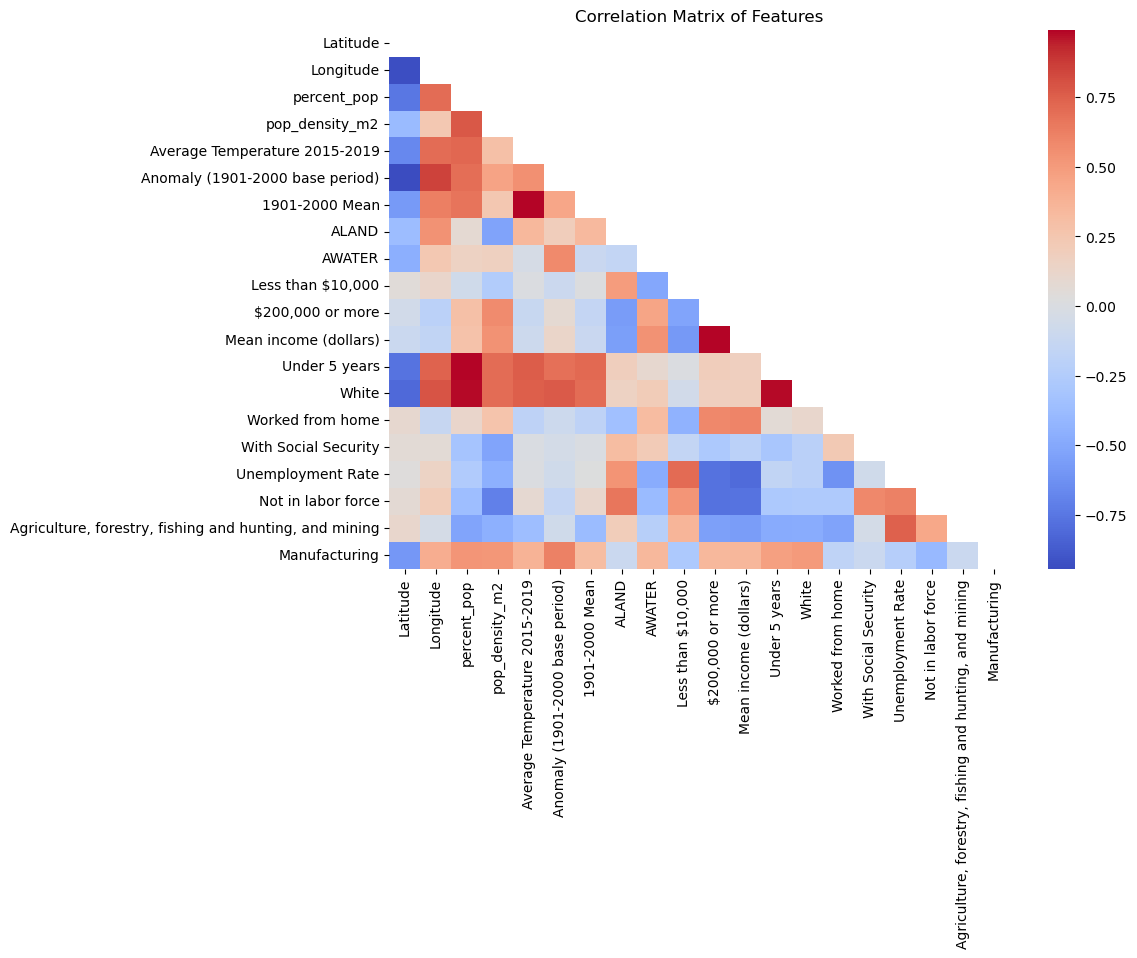

In [266]:
#Correlation Matrix of Features: Checks for Multicollinearity

mask_state = np.triu(np.ones_like(X_train.corr()))

plt.figure(figsize=(10, 7))
sns.heatmap(X_train.corr(), cmap='coolwarm', mask=mask_state)
plt.title('Correlation Matrix of Features')
plt.show()

Model Tells us:

Latitude Highly correlated with 2 features, don't use

## Frequentist GLM

In [267]:
X_train.columns

Index(['Latitude', 'Longitude', 'percent_pop', 'pop_density_m2',
       'Average Temperature 2015-2019', 'Anomaly (1901-2000 base period)',
       '1901-2000 Mean', 'ALAND', 'AWATER', 'Less than $10,000',
       '$200,000 or more', 'Mean income (dollars)', 'Under 5 years', 'White',
       'Worked from home', 'With Social Security', 'Unemployment Rate',
       'Not in labor force',
       'Agriculture, forestry, fishing and hunting, and mining',
       'Manufacturing'],
      dtype='object')

In [268]:
X_trwconstant = sm.add_constant(X_train)

In [269]:
link_function = sm.families.links.identity()

glm_model = sm.GLM(y_train, X_trwconstant, family=sm.families.Gaussian(link=link_function)).fit()
glm_predictions = glm_model.predict(sm.add_constant(X_test))

In [270]:
np.sqrt(mean_squared_error(y_test, glm_predictions))

2.815684712814398

In [271]:
y_test - glm_predictions

756     1.657362
2741   -1.089808
1467    6.306281
2023   -0.758085
964    -3.095226
          ...   
3299   -2.341589
1608    1.390679
2781   -2.530937
305    -1.083755
1780    4.274842
Length: 863, dtype: float64

In [272]:
summary_df = pd.DataFrame(glm_model.summary().tables[1]).drop(columns=[3])
summary_df.columns = summary_df.iloc[0]

# remove the first row (now column names)
summary_df = summary_df.iloc[1:]
latex_table = summary_df.to_latex(index=False)

# print the LaTeX code
print(latex_table)

\begin{tabular}{llllll}
\toprule
                                                   &       coef &   std err &  P>|z| &    [0.025 &    0.975] \\
\midrule
                                             const &    19.6244 &     0.064 &  0.000 &    19.499 &    19.750 \\
                                          Latitude &    -2.9371 &     1.003 &  0.003 &    -4.903 &    -0.971 \\
                                         Longitude &   -12.8495 &     0.492 &  0.000 &   -13.814 &   -11.885 \\
                                       percent\_pop &   -82.4761 &     6.239 &  0.000 &   -94.705 &   -70.247 \\
                                    pop\_density\_m2 &    16.5313 &     1.466 &  0.000 &    13.657 &    19.405 \\
                     Average Temperature 2015-2019 &   337.2966 &    42.146 &  0.000 &   254.692 &   419.902 \\
                   Anomaly (1901-2000 base period) &   -50.1321 &     5.367 &  0.000 &   -60.651 &   -39.613 \\
                                    1901-2000 Mean &  -310.

/var/folders/4k/z9cwlry95cqggtz262bmpdz40000gn/T/ipykernel_15431/3006371720.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = summary_df.to_latex(index=False)


In [273]:
coef_all = glm_model.params

In [274]:
coef_all

const                                                      19.624356
Latitude                                                   -2.937122
Longitude                                                 -12.849536
percent_pop                                               -82.476104
pop_density_m2                                             16.531260
Average Temperature 2015-2019                             337.296574
Anomaly (1901-2000 base period)                           -50.132116
1901-2000 Mean                                           -310.713927
ALAND                                                       6.236347
AWATER                                                      2.304884
Less than $10,000                                          -0.440629
$200,000 or more                                            8.069326
Mean income (dollars)                                      -7.238030
Under 5 years                                              53.239747
White                             

## Bayesian GLM

(<AxesSubplot:xlabel='Average Temperature 2015-2019', ylabel='Density'>,
 -0.008109597684357189,
 0.9992355440967631)

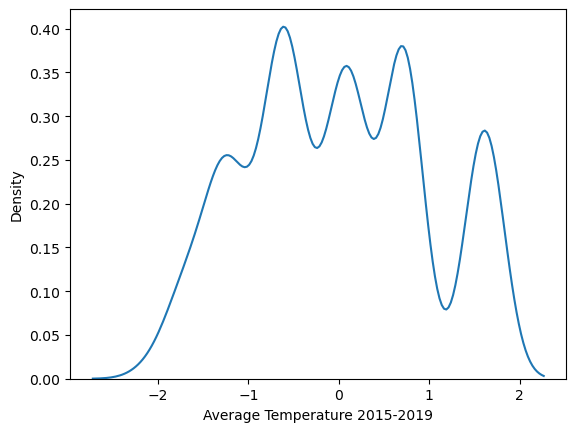

In [275]:
sns.kdeplot(X_train["Average Temperature 2015-2019"]), X_train["Average Temperature 2015-2019"].mean(), X_train["Average Temperature 2015-2019"].std()

(<AxesSubplot:xlabel='Anomaly (1901-2000 base period)', ylabel='Density'>,
 -0.009945411941695617,
 1.0020944542609485)

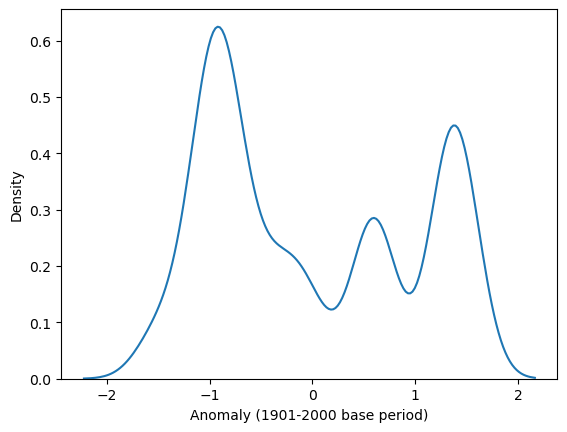

In [276]:
sns.kdeplot(X_train["Anomaly (1901-2000 base period)"]), X_train["Anomaly (1901-2000 base period)"].mean(), X_train["Anomaly (1901-2000 base period)"].std()

(<AxesSubplot:xlabel='1901-2000 Mean', ylabel='Density'>,
 -0.007169009723241096,
 0.9997691142331032)

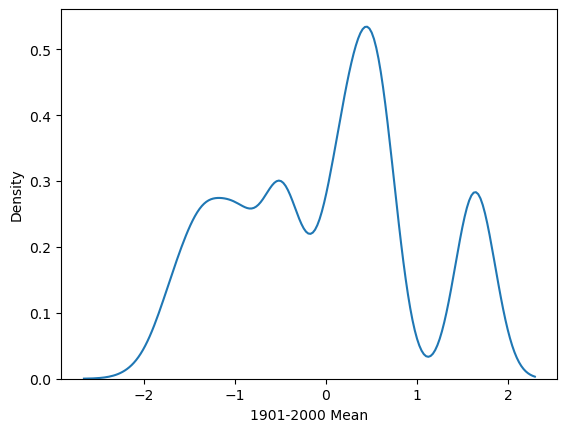

In [277]:
sns.kdeplot(X_train["1901-2000 Mean"]), X_train["1901-2000 Mean"].mean(), X_train["1901-2000 Mean"].std()

(<AxesSubplot:xlabel='Less than $10,000', ylabel='Density'>,
 -0.0146712967638609,
 1.0102810348145177)

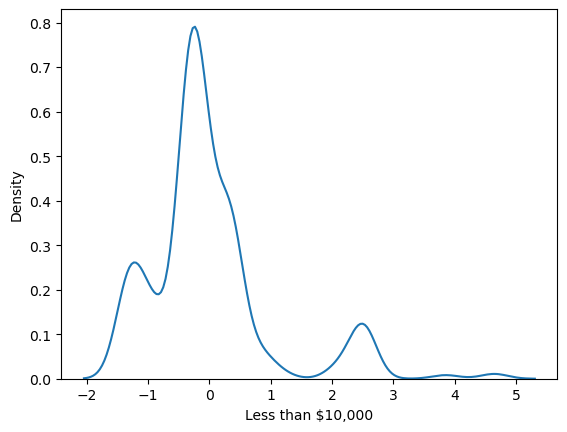

In [278]:
sns.kdeplot(X_train["Less than $10,000"]), X_train["Less than $10,000"].mean(), X_train["Less than $10,000"].std()

(<AxesSubplot:xlabel='$200,000 or more', ylabel='Density'>,
 0.00771307832198749,
 1.0018069707551276)

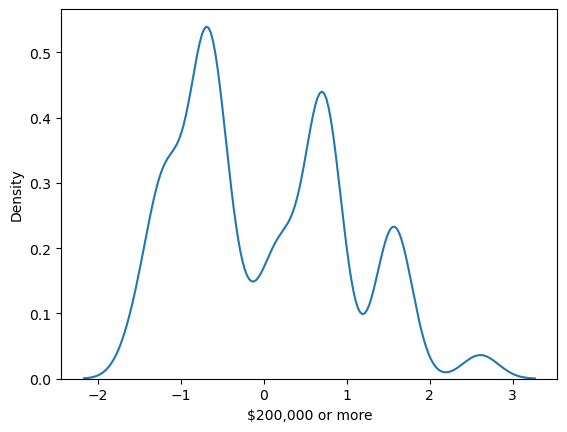

In [279]:
sns.kdeplot(X_train["$200,000 or more"]), X_train["$200,000 or more"].mean(), X_train["$200,000 or more"].std()

(<AxesSubplot:xlabel='Mean income (dollars)', ylabel='Density'>,
 0.009192624348311255,
 1.0021592868261444)

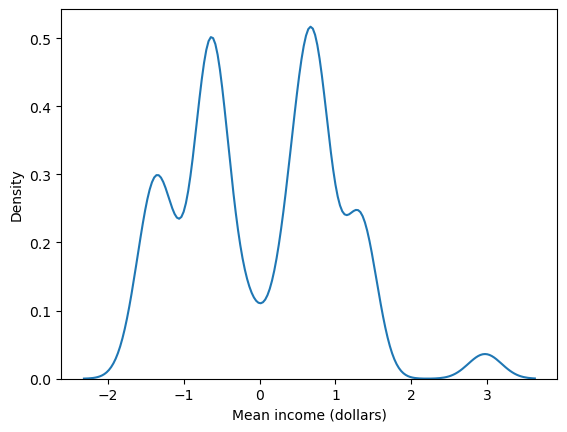

In [280]:
sns.kdeplot(X_train["Mean income (dollars)"]), X_train["Mean income (dollars)"].mean(), X_train["Mean income (dollars)"].std()

(<AxesSubplot:xlabel='Under 5 years', ylabel='Density'>,
 -0.018011126992475972,
 0.9977727187590777)

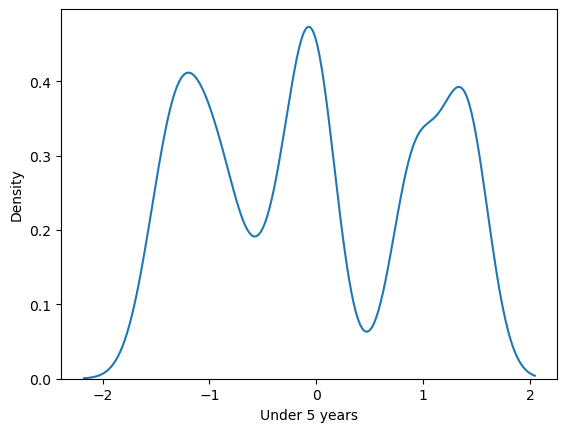

In [281]:
sns.kdeplot(X_train["Under 5 years"]), X_train["Under 5 years"].mean(), X_train["Under 5 years"].std()

(<AxesSubplot:xlabel='White', ylabel='Density'>,
 -0.0165567851048032,
 0.9940663523128744)

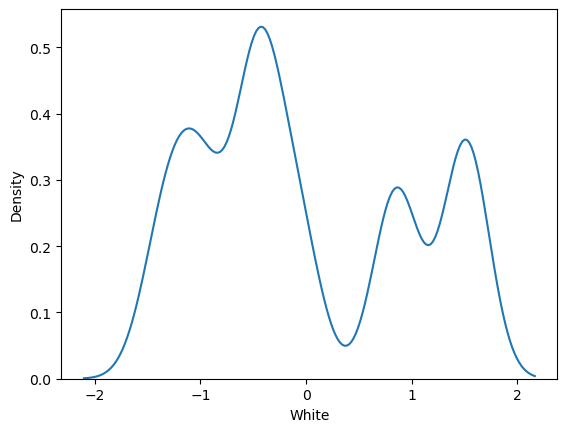

In [282]:
sns.kdeplot(X_train["White"]), X_train["White"].mean(), X_train["White"].std()

In [283]:
X_train.columns, len(X_train.columns)

(Index(['Latitude', 'Longitude', 'percent_pop', 'pop_density_m2',
        'Average Temperature 2015-2019', 'Anomaly (1901-2000 base period)',
        '1901-2000 Mean', 'ALAND', 'AWATER', 'Less than $10,000',
        '$200,000 or more', 'Mean income (dollars)', 'Under 5 years', 'White',
        'Worked from home', 'With Social Security', 'Unemployment Rate',
        'Not in labor force',
        'Agriculture, forestry, fishing and hunting, and mining',
        'Manufacturing'],
       dtype='object'),
 20)

In [284]:
import theano.tensor as tt

with pm.Model() as model:
    # Constant
    beta0 = pm.Normal('beta0', mu=0, sd=10)
    # Latitude
    beta1 = pm.Normal('beta1', mu=0, sd=10)
    # Longitude
    beta2 = pm.Normal('beta2', mu=0, sd=10)
    # Percent_pop
    beta3 = pm.Normal('beta3', mu=0, sd=10)
    # Pop_density_m2
    beta4 = pm.Normal('beta4', mu=0, sd=10)
     # Avg Temp 2015-2019
    beta5 = pm.Normal('beta5', mu=0, sd=10)
    # Anomaly (1901-2000 base period)
    beta6 = pm.Normal('beta6', mu=0, sd=10)
    # 1901-2000 mean
    beta7 = pm.Normal('beta7', mu=0, sd=10)
    # ALAND
    beta8 = pm.Normal('beta8', mu=0, sd=10)
    # AWATER
    beta9 = pm.Normal('beta9', mu=0, sd=10)
    # < 10k
    beta10 = pm.Normal('beta10', mu=-0, sd=10)
    # > 200k
    beta11 = pm.Normal('beta11', mu=-0, sd=10)
    # Mean income
    beta12 = pm.Normal('beta12', mu=0, sd=10)
    # Under 5 years
    beta13 = pm.Normal('beta13', mu=0, sd=10)
    # White
    beta14 = pm.Normal('beta14', mu=0, sd=10)
     # Worked from home
    beta15 = pm.Normal('beta15', mu=0, sd=10)
     # w/ Social Security
    beta16 = pm.Normal('beta16', mu=0, sd=10)
     # Unemployment Rate
    beta17 = pm.Normal('beta17', mu=0, sd=10)
    # Not in labor force
    beta18 = pm.Normal('beta18', mu=0, sd=10)
     # Agriculture, forestry, fishing and hunting, and mining 
    beta19 = pm.Normal('beta19', mu=0, sd=10)
     # Manufacturing
    beta20 = pm.Normal('beta20', mu=0, sd=10)

    # Likelihood
    betas = tt.stack([beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta20])

    mu = tt.dot(pm.Data("X", np.hstack([np.ones((X_train.shape[0], 1)), X_train])), betas)
    
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed = pm.Data("y", y_train))

    # Posterior sampling
    trace = pm.sample(1000, target_accept=0.95, init='adapt_diag')

    y_ppc = pm.sample_posterior_predictive(trace)
    y_ppc[y_obs.name] = y_ppc[y_obs.name] + 0.0
    ppc_y = az.from_pymc3(trace, posterior_predictive=y_ppc)

/Users/natalia/opt/anaconda3/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta20, beta19, beta18, beta17, beta16, beta15, beta14, beta13, beta12, beta11, beta10, beta9, beta8, beta7, beta6, beta5, beta4, beta3, beta2, beta1, beta0]


KeyboardInterrupt: 

In [ ]:
with model:
    pm.set_data({"X": np.hstack([np.ones((X_test.shape[0], 1)), X_test]), "y": y_test})
    trace_ppc = pm.sample_posterior_predictive(trace, samples=500)

# Calculate the mean of the posterior predictive samples
y_pred = trace_ppc["y_obs"].mean(axis=0)

# Calculate the mean squared error between the predicted and actual values
rmse = np.sqrt(((y_pred - y_test)**2).mean())

print("Mean Squared Error:", rmse)

In [ ]:
# Plot PPC samples
az.plot_ppc(ppc_y)
plt.xlabel('y = PM2.5')
plt.title('Bayesian  Regression')

plt.show()

In [ ]:
summary_df = pd.DataFrame(pm.summary(trace)).drop(columns=["sd", "mcse_mean", "mcse_sd"]).reset_index().drop(columns=["index"])
cols = list(X_train.columns)
cols.insert(0, "Constant")
cols.append("Sigma")
summary_df.insert(0, 'Coefficients', cols)
summary_df["Coefficients"] = cols

latex_table = summary_df.to_latex(index=False)

# print the LaTeX code
print(latex_table)


In [ ]:
# Plot the posterior distribution for the intercept and Temp_Anomaly coefficients
az.plot_posterior(trace, ['beta0'], round_to = 3)
plt.show()

In [ ]:
summary = pm.summary(trace)
summary

In [ ]:
# Random Forest
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print("Train Root Mean squared error: " + str(mean_squared_error(y_train, random_forest.predict(X_train))**(1/2)))
print("Root Mean squared error: " + str(mean_squared_error(y_test, y_pred)**(1/2)))
print('R-squared value: ' + str(r2_score(y_test, y_pred)))
importances = random_forest.feature_importances_
for feature, importance in zip(X.columns, importances):
    print('Feature: %s, Importance: %.3f' % (feature, importance))

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(random_forest.estimators_[0], feature_names=X_train.columns, filled=True)
plt.show()

# Question 2: Causal Inference

In [285]:
# read a CSV file named 'new_merged_df.csv' into a Pandas DataFrame, and drop some columns from it
merged = pd.read_csv('new_merged_df.csv').drop(columns=['pm25_daily_average(ug/m3)', 'pm25_daily_average_stderr(ug/m3)', 
       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAMELSAD', 'CSAFP', 'month',
       'CBSAFP', 'FUNCSTAT', 'INTPTLAT', 'INTPTLON'])

# read a CSV file named 'pm25_Jan2015.csv' into a Pandas DataFrame, and select only specific columns from it
avg_pm25 = pd.read_csv("pm25_Jan2015.csv")[["Latitude", "Longitude", "pm25_daily_average(ug/m3)", "year"]].rename(columns={"pm25_daily_average(ug/m3)": "avg_pm25"})

In [286]:
avg_pm25

,Latitude,Longitude,avg_pm25,year
0,32.54677,-117.05292,9.395610,2015.0
1,32.54896,-117.09137,9.666635,2015.0
2,32.55551,-117.04743,9.339426,2015.0
3,32.56007,-116.95471,8.169016,2015.0
4,32.56078,-117.05852,9.508777,2015.0
...,...,...,...,...
7979,41.93657,-122.63750,11.019877,2015.0
7980,41.50297,-120.55145,9.771432,2015.0
7981,41.50386,-121.24958,10.102926,2015.0
7982,41.59887,-120.12045,9.013781,2015.0


In [287]:
# merge two dataframes 'merged' and 'avg_pm25' based on common columns 'Latitude', 'Longitude', and 'year'
# use the 'left' join type to retain all rows from the left dataframe and matching rows from the right dataframe
merged = pd.merge(merged, avg_pm25, on = ["Latitude", "Longitude", "year"], how = "left")

In [288]:
merged

,Unnamed: 0,County,Geography,Latitude,Longitude,year,geometry,NAME,ALAND,AWATER,...,Median income (dollars),Mean income (dollars),Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing,avg_pm25
0,0,Imperial,Imperial County,32.66863,-115.48641,2015.0,POINT (-12855888.354743218 3851402.2861599475),Imperial,10817291640,790230304,...,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.355768
1,1,Imperial,Imperial County,32.67302,-115.51441,2015.0,POINT (-12859005.300485428 3851982.8288422064),Imperial,10817291640,790230304,...,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023,12.791235
2,2,Imperial,Imperial County,32.67664,-115.49759,2015.0,POINT (-12857132.906650286 3852461.5665919865),Imperial,10817291640,790230304,...,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.209774
3,3,Imperial,Imperial County,32.67737,-115.47770,2015.0,POINT (-12854918.761978408 3852558.109980503),Imperial,10817291640,790230304,...,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.499890
4,4,Imperial,Imperial County,32.69699,-115.49547,2015.0,POINT (-12856896.909329804 3855153.1745244544),Imperial,10817291640,790230304,...,48472.0,64050.0,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.063413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,3323,Siskiyou,NaN,41.93657,-122.63750,2015.0,POINT (-13651944.052160086 5151482.668153119),Siskiyou,16261974847,179108278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.019877
3324,3324,Modoc,NaN,41.50297,-120.55145,2015.0,POINT (-13419726.02839078 5086815.0992424),Modoc,10140955630,745425201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.771432
3325,3325,Modoc,NaN,41.50386,-121.24958,2015.0,POINT (-13497441.504498288 5086947.389535307),Modoc,10140955630,745425201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.102926
3326,3326,Modoc,NaN,41.59887,-120.12045,2015.0,POINT (-13371747.327858878 5101080.224413083),Modoc,10140955630,745425201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.013781


In [289]:
# Load asthma.csv into a Pandas DataFrame
# Filter the DataFrame to only include data from 2015 and for the 'Total population' stratum
# Group the DataFrame by county and calculate the mean of each numerical column
# Remove any rows with missing values
asthma = pd.read_csv("asthma.csv", encoding="iso-8859-1")
asthma.drop(columns=["COMMENT"], inplace = True)
asthma = asthma[(asthma.YEAR == 2015) & (asthma.STRATA == "Total population")]
asthma = asthma.groupby("COUNTY").agg(np.mean).reset_index().dropna()

In [290]:
# left join of two pandas dataframes "merged" and "asthma" on the columns "NAME" and "year" of "merged" 
merged = pd.merge(merged, asthma, left_on = ["NAME", "year"], right_on = ["COUNTY", "YEAR"], how = "left").drop(columns=["YEAR", "COUNTY", "NAME"])

In [291]:
# Drop rows with missing values
merged.dropna(inplace = True)

In [292]:
# Calculate the 0.25 percentile value of the "percents" column in the "merged" DataFrame
cutoff = np.percentile(merged.percents, [0.25])

In [293]:
# Filters merged based on a minimum threshold for the counts column.
merged = merged[merged.counts > cutoff[0]]

In [294]:
# Group the data in merged dataframe by County and calculate the mean of avg_pm25 for each County
averages = merged.groupby("County")[["avg_pm25"]].agg(np.mean).reset_index().rename(columns={"avg_pm25": "county_pm25"})

# Merge the calculated averages with the original merged dataframe based on County and add a new column "county_pm25" to merged dataframe
merged = pd.merge(merged, averages, on="County", how = "left").rename(columns={"AGE-ADJUSTED HOSPITALIZATION RATE": "aahr"})

In [295]:
merged

,Unnamed: 0,County,Geography,Latitude,Longitude,year,geometry,ALAND,AWATER,percents,...,Household income in the past 12 months,Worked from home,With Social Security,Unemployment Rate,Not in labor force,"Agriculture, forestry, fishing and hunting, and mining",Manufacturing,avg_pm25,aahr,county_pm25
0,0,Imperial,Imperial County,32.66863,-115.48641,2015.0,POINT (-12855888.354743218 3851402.2861599475),10817291640,790230304,0.003382,...,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.355768,8.7,9.794311
1,1,Imperial,Imperial County,32.67302,-115.51441,2015.0,POINT (-12859005.300485428 3851982.8288422064),10817291640,790230304,0.003382,...,43.3,0.029,0.391,0.113,0.491,0.103,0.023,12.791235,8.7,9.794311
2,2,Imperial,Imperial County,32.67664,-115.49759,2015.0,POINT (-12857132.906650286 3852461.5665919865),10817291640,790230304,0.003382,...,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.209774,8.7,9.794311
3,3,Imperial,Imperial County,32.67737,-115.47770,2015.0,POINT (-12854918.761978408 3852558.109980503),10817291640,790230304,0.003382,...,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.499890,8.7,9.794311
4,4,Imperial,Imperial County,32.69699,-115.49547,2015.0,POINT (-12856896.909329804 3855153.1745244544),10817291640,790230304,0.003382,...,43.3,0.029,0.391,0.113,0.491,0.103,0.023,13.063413,8.7,9.794311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3305,Shasta,Shasta County,40.87657,-121.64382,2015.0,POINT (-13541328.100548629 4994152.778538148),9778179454,186530168,0.006012,...,43.9,0.057,0.424,0.050,0.440,0.017,0.068,10.765210,5.9,14.009281
3227,3306,Shasta,Shasta County,40.92356,-121.45228,2015.0,POINT (-13520005.965282084 5001073.310880446),9778179454,186530168,0.006012,...,43.9,0.057,0.424,0.050,0.440,0.017,0.068,10.430016,5.9,14.009281
3228,3307,Shasta,Shasta County,40.99521,-122.35904,2015.0,POINT (-13620946.02675379 5011635.165611714),9778179454,186530168,0.006012,...,43.9,0.057,0.424,0.050,0.440,0.017,0.068,11.845235,5.9,14.009281
3229,3308,Humboldt,Humboldt County,41.09922,-123.67252,2015.0,POINT (-13767161.951520942 5026987.624991309),9240992572,1254297982,0.000251,...,38.0,0.077,0.358,0.066,0.392,0.058,0.044,11.538303,5.2,11.412850


(<AxesSubplot:xlabel='county_pm25', ylabel='Count'>, 18.584699999999998)

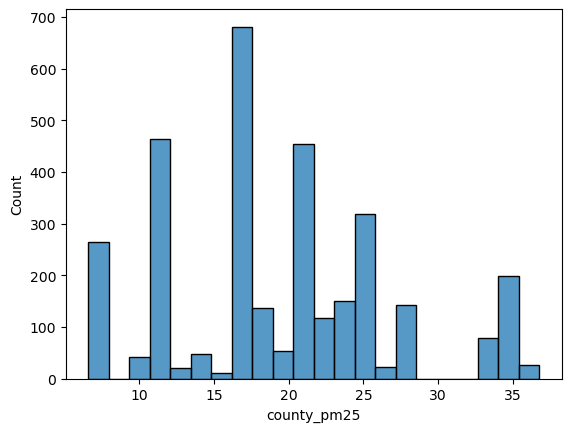

In [296]:
sns.histplot(merged.county_pm25), merged.county_pm25.median()

In [297]:
# This code adds a new column called "treatment" to the "merged" DataFrame, which is assigned a 
# value of 1 if the "county_pm25" value for a row is greater than the median of all rows, and 
# 0 otherwise.
merged['treatment'] = np.where(merged["county_pm25"] > merged["county_pm25"].median(), 1, 0)

In [298]:
# List of potential confounding variables
confounders = ['ALAND', 'AWATER', 'percent_pop',
       'Average Temperature 2015-2019', 'Rank out of 125 Years',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean', 'pop_density_m2',
        'Total population', 'Male', 'Female',
       'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years',
       '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',
       '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',
       '85 years and over', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Hispanic or Latino (of any race)', 'Less than $10,000',
       '$10,000 to $14,999', '$15,000 to $24,999', '$25,000 to $34,999',
       '$35,000 to $49,999', '$50,000 to $74,999', '$75,000 to $99,999',
       '$100,000 to $149,999', '$150,000 to $199,999', '$200,000 or more',
       'Median income (dollars)',
       'Household income in the past 12 months', 'Agriculture, forestry, fishing and hunting, and mining', 'Manufacturing', 
       'Not in labor force', 'Unemployment Rate', 'With Social Security', 'Worked from home']

# Outcome variable
outcome = ["aahr"]

# treatment variable
treatment = ["treatment"]

# Select the confounding, outcome, treatment, and county variables from the merged dataset
merged = merged[confounders + outcome + treatment + ["County"]]

In [300]:
# Group the data in the 'merged' DataFrame by the values in the 'County' column and aggregate using the mean
causal = merged.groupby("County").agg(np.mean)

# create a StandardScaler object
scaler = StandardScaler()

# fit and transform the continuous covariates using the StandardScaler
causal[confounders] = scaler.fit_transform(causal[confounders])

In [301]:
# calculates the treatment effect using logistic regression. It takes in a model, input features, 
# treatment indicator, and outcome variable as arguments and returns the estimated treatment effect.
def estimate_treatment_effect(lr, X, Y, Z):
    outcome = np.mean(((Z * Y) / lr.predict_proba(X)[:, 1]) - (((1 - Z) * Y) / lr.predict_proba(X)[:, 0]))
    return outcome

In [302]:
# Set the significance level
alpha = 0.05

# Set the number of bootstrap samples
n_bootstrap = 1000

# Initialize an array to store the ATE estimates
ate_bootstrap = np.zeros(n_bootstrap)

# Loop over the bootstrap samples
for i in range(n_bootstrap):
    # Draw a bootstrap sample from the causal_weighted dataset
    causal_weighted_bootstrap = causal.sample(frac=1, replace=True)
    
    Z, Y, X = causal_weighted_bootstrap["treatment"], causal_weighted_bootstrap["aahr"], causal_weighted_bootstrap.iloc[:, :-2]

    lr = LogisticRegression(max_iter = 200, random_state=42)
    lr.fit(X, Z)

    # Calculate the ATE using IPW
    ate_bootstrap[i] = estimate_treatment_effect(lr, X, Y, Z)
    
# Calculate the mean and standard deviation of the ATE estimates
ate_mean = np.mean(ate_bootstrap)

# Calculate the confidence interval using the normal distribution
lower_ci, upper_ci = np.percentile(ate_bootstrap, [2.5, 97.5])


# Print the results
print("ATE estimate: {:.2f}".format(ate_mean))
print("95% confidence interval: [{:.2f}, {:.2f}]".format(lower_ci, upper_ci))


ATE estimate: 0.74
95% confidence interval: [-1.77, 3.09]


<AxesSubplot:ylabel='Count'>

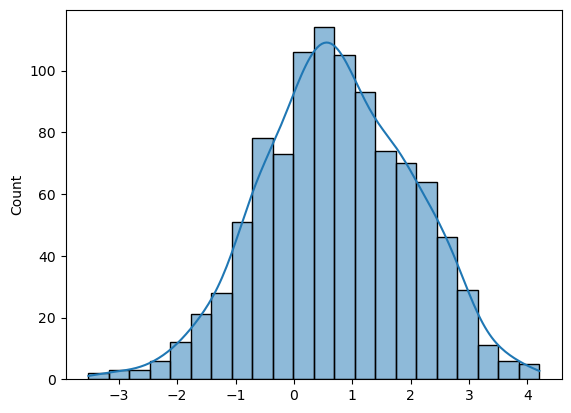

In [304]:
# create a histogram plot from ate_bootstrap with a kernel density estimate
sns.histplot(ate_bootstrap, kde = True)